In [17]:
import xarray as xr
import numpy as np
import pandas as pd
from PY_PAD_on_sphere_library import calculate_attributions_from_xarrays
from postprocess import     aggregate_transportplan_at_gridpoints, postprocess_residue_df, get_latlon_df

## Read sample data

Both sample fields are on a 0.25 deg grid

In [38]:
fcst = xr.open_dataarray("PY_PAD_on_sphere_example_field_A.nc")
obs = xr.open_dataarray("PY_PAD_on_sphere_example_field_B.nc")

Text(0.5, 1.0, 'Observed precipitation (mm)')

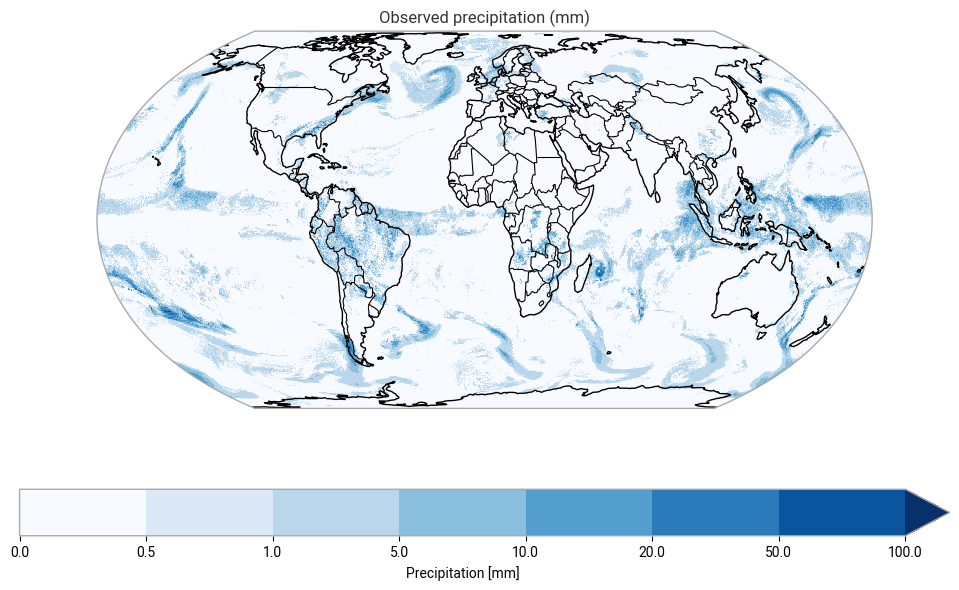

In [47]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
obs.plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    cmap="Blues", 
    levels=[0,0.5,1,5,10,20,50,100],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": "Precipitation [mm]"
                  },
)
ax.coastlines(color="black")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title('Observed precipitation (mm)')

Text(0.5, 1.0, 'Precipitation error (mm)')

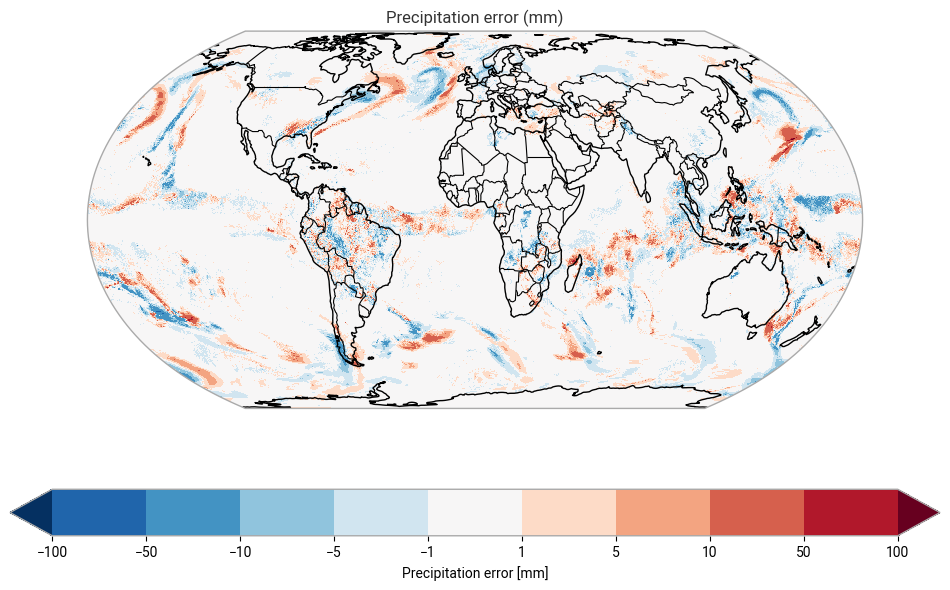

In [48]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(fcst-obs).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    levels=[-100,-50,-10,-5,-1,1,5,10,50,100],
    cbar_kwargs = {"orientation": "horizontal",
                  "label": "Precipitation error [mm]"},
)
ax.coastlines(color="black")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title('Precipitation error (mm)')

### Reshape the data to have a single "gridpoint" dimension instead of "lat" and "lon"

In [3]:
fcst = fcst.stack(stack=("lat", "lon"))
obs = obs.stack(stack=("lat", "lon"))
fcst = fcst.assign_coords(gridpoint=('stack', range(fcst.sizes['stack']))).swap_dims({"stack": "gridpoint"}).drop_vars("stack")
obs = obs.assign_coords(gridpoint=('stack', range(obs.sizes['stack']))).swap_dims({"stack": "gridpoint"}).drop_vars("stack")

In [4]:
fcst

<xarray.DataArray 'precipitation' (gridpoint: 1038240)> Size: 4MB
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    lat        (gridpoint) float32 4MB -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon        (gridpoint) float32 4MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * gridpoint  (gridpoint) int64 8MB 0 1 2 3 ... 1038236 1038237 1038238 1038239

### Compute grid-area (used internally to convert precipitation from heigh in mm to volume in m^3)

In [5]:
dlat = 0.25 # in deg
dlon = 0.25 # in deg
Earth_radius = 6371 # in km
area = (
    np.deg2rad(dlat) * Earth_radius
    * np.deg2rad(dlon) * Earth_radius * np.cos(np.deg2rad(fcst.lat))
) # in km^2

## Compute PAD-on-sphere attributions

In [6]:
attr_df, nonattr_ds = calculate_attributions_from_xarrays(fcst, obs, area)

----- preprocessing: 0.0195145 s
----- kdtree construction: 0.4338 s
----- attribution: 7.063 s


In [7]:
attr_df

,distance_m,volume_m3,gridpoint_fcst,gridpoint_obs
0,0,25.725337,1913,1913
1,0,25.725337,1914,1914
2,0,25.725337,1915,1915
3,0,25.725337,1916,1916
4,0,25.725337,1917,1917
...,...,...,...,...
1331231,2991987,178823.842918,301571,169002
1331232,2999401,470864.635009,301571,176191
1331233,3012885,377702.620858,301572,167563
1331234,3024321,193983.855489,301572,207844


In [8]:
nonattr_ds

<xarray.Dataset> Size: 33MB
Dimensions:    (gridpoint: 1038240)
Coordinates:
    lat        (gridpoint) float64 8MB -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
    lon        (gridpoint) float64 8MB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * gridpoint  (gridpoint) int64 8MB 0 1 2 3 ... 1038236 1038237 1038238 1038239
Data variables:
    error      (gridpoint) float64 8MB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0

In [9]:
latlon_df = get_latlon_df(obs)

In [10]:
distance_ds = aggregate_transportplan_at_gridpoints(attr_df, latlon_df).to_xarray()

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [41]:
def reshape_octahedral_grid_data(ds, fill_na_lons=359.9999):
    # get unique list of lats, in descending order
    lats = ds.lat.groupby(ds.lat).mean().sortby("lat", ascending=True)
    nlats = ds.lat.groupby(ds.lat).count().sizes["lat"]

    # get number of longitudes per each lat
    nlons = ds.lat.groupby(ds.lat).count().sortby("lat", ascending=True).rename({"lat": "j"}).assign_coords({"j": range(nlats)}).rename("nlon")

    # expand lats to depend also on i coordinate
    lats = lats.rename({"lat": "j"}).assign_coords({"j": range(nlats)}).expand_dims(dim={"i": range(nlons.max().values)})

    # get the indices to slice the data in consecutive longitude chunks
    idx = np.insert(nlons.cumsum().values, 0, 0)

    # slice the data and reshape it to an (i,j)-dependant array
    tmpls = list()
    for j in lats.j.values:
        ads = ds.isel(gridpoint=slice(idx[j], idx[j+1])).rename({"gridpoint": "i"}).assign_coords({"i": range(nlons.isel(j=j).values)})
        tmpls.append(ads)
    ds2 = xr.concat(tmpls, dim="j").assign_coords({"j": lats.j})

    # fill nan longitudes (this value should be changed for regional plots)
    ds2['lon'] = ds2.lon.fillna(fill_na_lons)
    # fill nan latitudes 
    ds2['lat'] = lats

    ds2 = ds2.set_coords(("lat", "lon"))
    return ds2

In [42]:
kk = reshape_octahedral_grid_data(distance_ds)

Text(0.5, 1.0, 'transported distance')

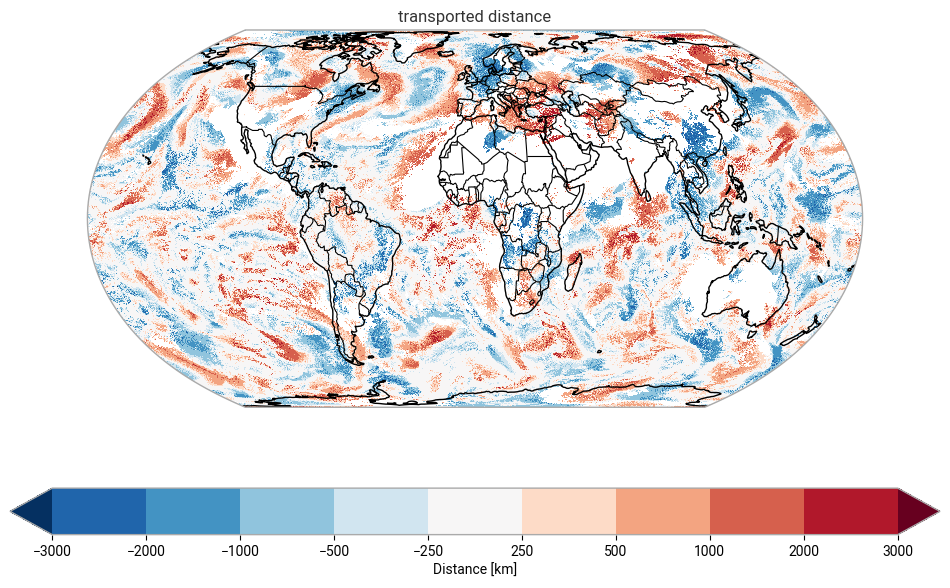

In [51]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(kk.dist/1000).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    levels=[-3000,-2000,-1000,-500,-250,250,500,1000,2000,3000],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": "Distance [km]"
                  },
)
ax.coastlines(color="black")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title('transported distance')

Text(0.5, 1.0, 'Volume (shaded) and distance (contours) transported')

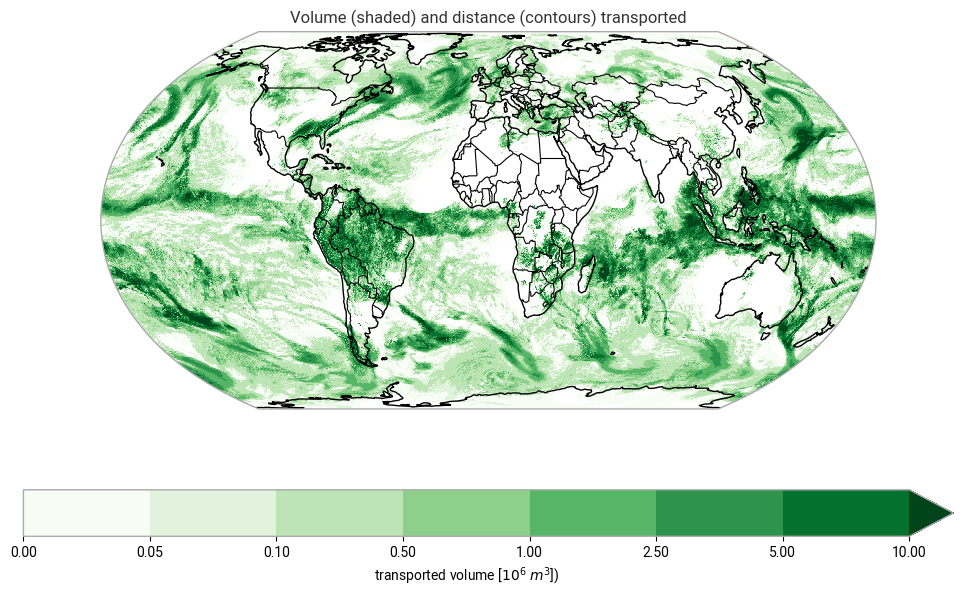

In [61]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(kk.volume / 1000000).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    cmap="Greens", levels=[0, 0.05, 0.1, 0.5, 1, 2.5, 5, 10],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": r'transported volume [$10^6$ $m^3$])'
                  },
)
ax.coastlines(color="black")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title("Volume (shaded) and distance (contours) transported")

In [86]:
kk2 = kk.rolling(i=20,center=True).mean().rolling(j=20,center=True).mean()

Text(0.5, 1.0, 'Volume (shaded) and distance (contours) transported')

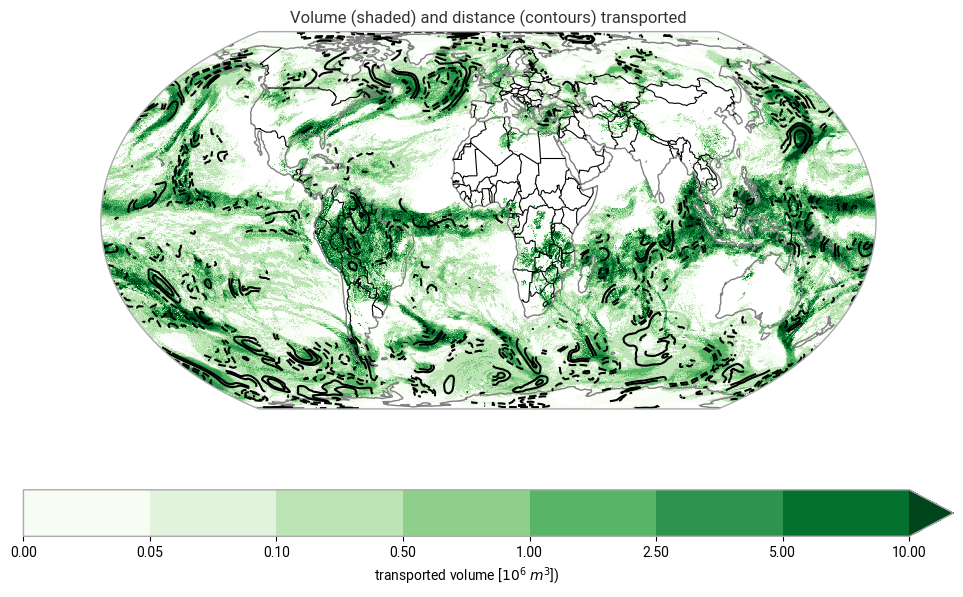

In [87]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(kk.volume / 1000000).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    cmap="Greens", levels=[0, 0.05, 0.1, 0.5, 1, 2.5, 5, 10],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": r'transported volume [$10^6$ $m^3$])'
                  },
)
ax.contour(kk2.lon.transpose(), kk2.lat, kk2.dist.transpose()/1000, 
           transform=ccrs.PlateCarree(),
           #levels=2,
           levels=[-1000,-500,-250,250,500,1000], 
           colors="black")
ax.coastlines(color="grey")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title("Volume (shaded) and distance (contours) transported")

In [89]:
kk3 = kk.coarsen(i=20,boundary="pad").mean().coarsen(j=20,boundary="pad").mean()

Text(0.5, 1.0, 'Volume (shaded) and distance (contours) transported')

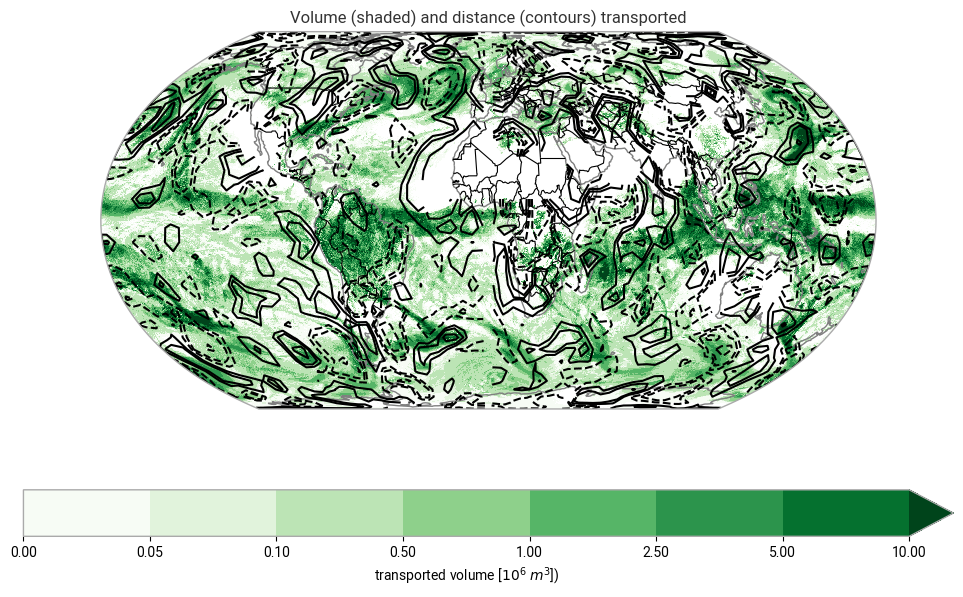

In [90]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(kk.volume / 1000000).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    cmap="Greens", levels=[0, 0.05, 0.1, 0.5, 1, 2.5, 5, 10],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": r'transported volume [$10^6$ $m^3$])'
                  },
)
ax.contour(kk3.lon.transpose(), kk3.lat, kk3.dist.transpose()/1000, 
           transform=ccrs.PlateCarree(),
           #levels=2,
           levels=[-1000,-500,-250,250,500,1000], 
           colors="black")
ax.coastlines(color="grey")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title("Volume (shaded) and distance (contours) transported")

Text(0.5, 1.0, 'Transported distanca*volume')

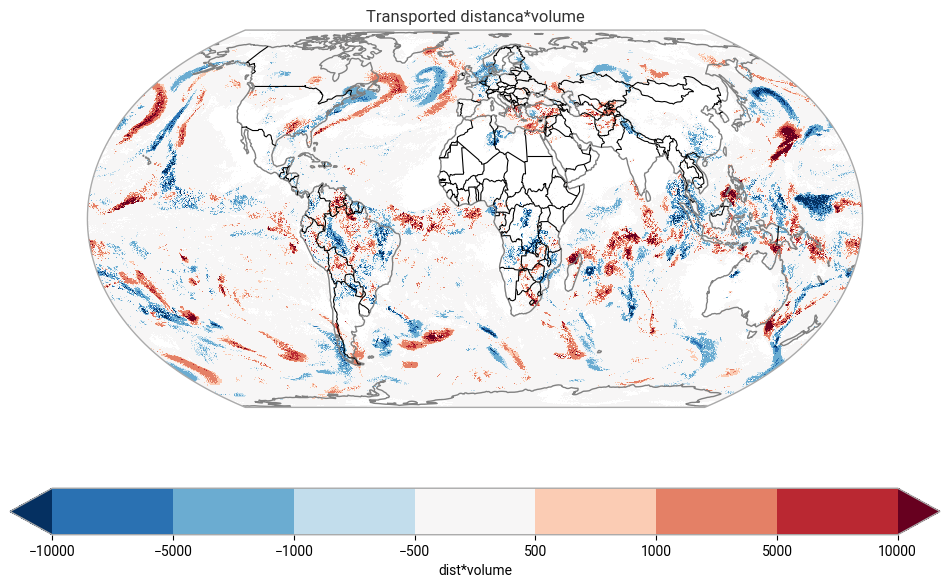

In [94]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
(kk.volume / 1000000 * kk.dist / 1000).plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    levels=[-10000,-5000,-1000,-500,500,1000,5000,10000],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": 'dist*volume'
                  },
)
ax.coastlines(color="grey")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title("Transported distance*volume")

In [64]:
qq = reshape_octahedral_grid_data(nonattr_ds)

Text(0.5, 1.0, 'unattributed precipitation in fcst (red) and obs (blue)')

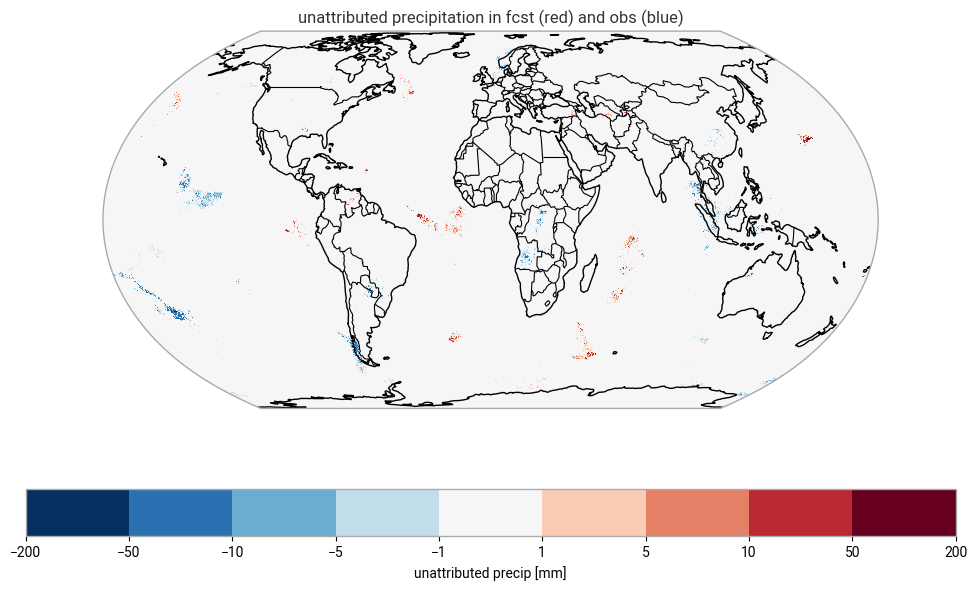

In [78]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.EqualEarth())
qq.error.plot(
    ax=ax, x="lon", y="lat", transform=ccrs.PlateCarree(),
    cmap="RdBu_r", 
    levels=[-200,-50,-10,-5,-1,1,5,10,50,200],
    cbar_kwargs = {"orientation": "horizontal",
                   "label": "unattributed precip [mm]"
                  },
)
ax.coastlines(color="black")
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.8, edgecolor="black")
plt.title('unattributed precipitation in fcst (red) and obs (blue)')